In [1]:
%matplotlib inline
#%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import scipy.constants as const
import time
import csv

from itertools import chain
from functools import reduce

from qutip import *

np.set_printoptions(threshold=np.inf)

In [2]:
'''
Import coupling factors and energy level splittings from file.

The notation used is to denote the ground/excited 'F' levels with g'F'/x'F'
The magnetic 'mF' sublevels -3,-2,-1,0,1,2,3 are denoted MMM,MM,M,[nothing],P,PP,PPP.
Examples: the F'=2,mF'=3 sublevel is denoted x2PPP,
          the F=1,mF'=-1 sublevel is denoted g1M.
          
Note: By default the parameter file has the energy splitting given wrt the F'=2 level. 
'''
imports = []
with open("./params/exp_params_5MHz.csv") as file:
    reader = csv.reader(file)
    for row in reader:
        imports.append(row)
        
imports = dict(map(lambda x: (str(x[0]), float(x[1])), imports))

deltaZ,deltaEx3,deltaEx1,deltaEx0,\
deltaZx3MMM,\
deltaZx3MM,deltaZx2MM,\
deltaZx3M,deltaZx2M,deltaZx1M,\
deltaZx3,deltaZx2,deltaZx1,deltaZx0,\
deltaZx3P,deltaZx2P,deltaZx1P,\
deltaZx3PP,deltaZx2PP,\
deltaZx3PPP = \
    [imports[delta]*2*np.pi for delta in 
        ["deltaZ", "deltaEx3","deltaEx1","deltaEx0",
         "deltaZx3MMM",
         "deltaZx3MM","deltaZx2MM",
         "deltaZx3M","deltaZx2M", "deltaZx1M",
         "deltaZx3","deltaZx2", "deltaZx1", "deltaZx0",
         "deltaZx3P","deltaZx2P", "deltaZx1P",
         "deltaZx3PP","deltaZx2PP",
         "deltaZx3PPP"]
     ]

CGg1Mx3MM, CGg1Mx2MM, \
CGg1x3M, CGg1x2M, CGg1x1M, CGg1Mx3M, CGg1Mx2M, CGg1Mx1M, \
CGg1Px3, CGg1Px2, CGg1Px1, CGg1Px0, CGg1x3, CGg1x2, CGg1x1, CGg1x0, CGg1Mx3, CGg1Mx2, CGg1Mx1, CGg1Mx0, \
CGg1Px3P, CGg1Px2P, CGg1Px1P, CGg1x3P, CGg1x2P, CGg1x1P, \
CGg1Px3PP,CGg1Px2PP = [imports[CG] for CG in [
    "CGg1Mx3MM", "CGg1Mx2MM",
    "CGg1x3M", "CGg1x2M", "CGg1x1M", "CGg1Mx3M", "CGg1Mx2M", "CGg1Mx1M",
    "CGg1Px3", "CGg1Px2", "CGg1Px1", "CGg1Px0", "CGg1x3", "CGg1x2", "CGg1x1", "CGg1x0", "CGg1Mx3", "CGg1Mx2", "CGg1Mx1", "CGg1Mx0",
    "CGg1Px3P", "CGg1Px2P", "CGg1Px1P", "CGg1x3P", "CGg1x2P", "CGg1x1P", 
    "CGg1Px3PP","CGg1Px2PP"]]

CGg2MMx3MMM, \
CGg2Mx3MM, CGg2Mx2MM, CGg2MMx3MM, CGg2MMx2MM, \
CGg2x3M, CGg2x2M, CGg2x1M, CGg2Mx3M, CGg2Mx2M, CGg2Mx1M, CGg2MMx3M, CGg2MMx2M, CGg2MMx1M, \
CGg2Px3, CGg2Px2, CGg2Px1, CGg2Px0, CGg2x3,  CGg2x2, CGg2x1, CGg2x0, CGg2Mx3, CGg2Mx2, CGg2Mx1, CGg2Mx0, \
CGg2PPx3P, CGg2PPx2P, CGg2PPx1P, CGg2Px3P, CGg2Px2P,  CGg2Px1P, CGg2x3P, CGg2x2P, CGg2x1P, \
CGg2PPx3PP, CGg2PPx2PP, CGg2Px3PP, CGg2Px2PP, \
CGg2PPx3PPP = [imports[CG] for CG in [
    "CGg2MMx3MMM",
    "CGg2Mx3MM","CGg2Mx2MM", "CGg2MMx3MM", "CGg2MMx2MM",
    "CGg2x3M", "CGg2x2M", "CGg2x1M", "CGg2Mx3M", "CGg2Mx2M", "CGg2Mx1M", "CGg2MMx3M", "CGg2MMx2M", "CGg2MMx1M",
    "CGg2Px3", "CGg2Px2", "CGg2Px1", "CGg2Px0", "CGg2x3", "CGg2x2", "CGg2x1", "CGg2x0", "CGg2Mx3", "CGg2Mx2", "CGg2Mx1", "CGg2Mx0",
    "CGg2PPx3P", "CGg2PPx2P", "CGg2PPx1P", "CGg2Px3P", "CGg2Px2P", "CGg2Px1P", "CGg2x3P", "CGg2x2P", "CGg2x1P",
    "CGg2PPx3PP", "CGg2PPx2PP", "CGg2Px3PP", "CGg2Px2PP",
    "CGg2PPx3PPP"]]

'''
Physical system parameters
'''
# List the excited levels to include in the simulation.
xlvls = [
    # 'x0',
    'x1M','x1','x1P',
    'x2MM','x2M','x2','x2P','x2PP',
    #'x3MMM', 'x3MM','x3M','x3','x3P','x3PP', 'x3PPP'
] 

# List the coupling rates of the system.
#   kappa:  Decay of the electric field out of the cavity.
#   gamma:  Decay of the atomic amplitude.
kappa = 3.543 * 2.*np.pi /2 
gamma = 3 * 2.*np.pi

# State the detuning of the vSTIRAP and repumping Raman resonances w.r.t.
# the energy zero defined above (with the E0shift parameter).
deltaOffsetVStirap = -10 * 2.*np.pi
deltaOffsetRepump =  -5 * 2.*np.pi

# The laser and cavity detuning for photon production
deltaL2_Pi_Stirap = deltaOffsetVStirap + 2*deltaZ + deltaZx2MM # For |F,mF>=|2,-2> <--> |F',mF'>=|2,-2>
deltaC = deltaOffsetVStirap -  deltaZ + deltaZx2MM # For |F,mF>=|1,-1> <--> |F',mF'>=|2,-2>

# The laser detuning for STIRAP repumping with: |F,mF>-|F',mF'>-|F,mF> <--> |1,-1>-|2,-2>-|2,-2>
deltaL1_Sigma = deltaOffsetRepump - deltaZ + deltaZx2MM # For |F,mF>=|1,-1> <--> |F',mF'>=|2,-2>
deltaL2_Pi = deltaOffsetRepump + 2*deltaZ + deltaZx2MM # For |F,mF>=|2,-2> <--> |F',mF'>=|2,-2>

# The laser detuning for STIRAP repumping with: |F,mF>-|F',mF'>-|F,mF> <--> |1,-1>-|2,-1>-|2,-2>
deltaL1_Pi = deltaOffsetRepump -  deltaZ + deltaZx2M # For |F,mF>=|1,-1> <--> |F',mF'>=|2,-1>
deltaL2_Sigma = deltaOffsetRepump + 2*deltaZ + deltaZx2M # For |F,mF>=|2,-1> <--> |F',mF'>=|2,-2>


'''
Cavity coupling.

Note g, the atom-cavity coupling rate, is given by
            d * A * coupling_factor
where,
    d: dipole moment of transition (D2 line for us).
    A: Angular dependence of the considered transition.
        e.g. A=np.sqrt(5/24) for F=1,mF=+/-1 <--> F=1,mF=0 in zero magnetic field.
'''
d = 3.584*10**(-29) # D2-line dipole moment

lambda_cav = 780.233 * 10**-9 # Resonance frequency of cavity
omega_cav = 2*np.pi * const.c / lambda_cav # Angular resonance frequency of cavity
L_cav = 339 * 10**-6 # Cavity length
R = 0.05 # Radius of curvature of cavity mirrors.
waist_cav = np.sqrt( (lambda_cav/np.pi)*np.sqrt( L_cav/2*( R - (L_cav/2) ))) # Cavity waist
V_mode = (np.pi * L_cav * waist_cav**2)/2 # Cavity mode volume.

coupling_factor = np.sqrt(omega_cav / (2*const.hbar*const.epsilon_0*V_mode))
coupling_factor /= 10**6 #Convert here so that the final coupling comes out in MHz.

'''
The variation in coupling of atoms in free-flight through the cavity mode can be
corrected for with an reduced averaged coupling.
Do so here if wanted.
'''
coupling_factor *= 0.7

print('Atom-cavity coupling for F=1,mF=+/-1 <--> F=1,mF=1 '
      'in zero magnetic field is: g={0}MHz'.format(
        np.round(d * np.sqrt(5/24) * coupling_factor / (2*np.pi),3)))   

Atom-cavity coupling for F=1,mF=+/-1 <--> F=1,mF=1 in zero magnetic field is: g=3.342MHz


In [3]:
'''
If you want to overide the atom-cavity coupling calculated from the cavity parameters (above)
do so here.

e.g. to set g=2MHz on F=1,mF=+/-1 <--> F=1,mF=1 tranistion in zero magnetic field use
    coupling_factor = 10*2*np.pi / (d*CGg1Mx1)
'''
# coupling_factor = 10*2*np.pi / (d*CGg1Mx1)

print('Atom-cavity coupling for F=1,mF=+/-1 <--> F=1,mF=0 '
      'in zero magnetic field is: g={0}MHz'.format(
        np.round(d * np.sqrt(5/24) * coupling_factor / (2*np.pi),3)))

Atom-cavity coupling for F=1,mF=+/-1 <--> F=1,mF=0 in zero magnetic field is: g=3.342MHz


In [4]:
'''
Here we perform the set up required before we can define and simulate the
Hamiltonian of the system.  This entails:
    1. Defining the size of our Hilbert space and how the states with it are
      labelled.
    2. Creating shorthand functions for the 'ket'/'bras' of the state vectors.
    3. Creating the operators who's expectation values we will wish to track
      through the simulations.  These are the number operators and for the
      population of each atomic state and each cavity mode in various
      polarisation bases (the cavity basis, {|H>,|V>} modes, {|+>,|->} modes
      etc.).
    4. Creating the collapse operators to account for spontaneous decay in our
      system.
'''

# Set where to truncate Fock states 0,1,2..,N-1 for cavity modes.
N = 2
cavStates = list(range(N))

# A dictionary of the atomic states.
atomStates = {
    "g1M":0, "g1":1, "g1P":2, # F=1,mF=-1,0,+1 respectively
    "g2MM":3, "g2M":4, "g2":5, "g2P":6, "g2PP":7 # F=2,mF=-2,..,+2 respectively
}
# Add the excited-states already configured.
for k,v in zip(xlvls, range(len(atomStates), len(atomStates)+len(xlvls))):
    atomStates[k]=v
M = len(atomStates)    

'''
State definitions - pre-calculated for speed.

We create string-indexed dictionaries for the kets (|k>), bras (<b|), and
ketbras (|k><b|).
'''
def ket(atom, cav):
    return tensor(basis(M, atomStates[atom]), basis(N, cav))

def bra(atom, cav):
    return ket(atom, cav).dag()

kets,bras = {},{}
ketbras = {}
import itertools
s=[ ["g1M", "g1", "g1P", "g2MM", "g2M", "g2", "g2P", "g2PP"] + xlvls, [0, 1] ]
states = list(map(list, list(itertools.product(*s))))
for state in states:
    kets[str(state)] = ket(*state)
    bras[str(state)] = bra(*state)
    
for x in list(map(list, list(itertools.product(*[states,states])))):
    ketbras[str(x)] = ket(*x[0])*bra(*x[1])


'''
Shorthand definitions for coding Hamiltonians.
'''
i=np.complex(0,1)

def ePit(x,t):
    return np.exp(i*t*x)
def ePmit(x,t):
    return np.exp(-i*t*x)
def kb(x,y):
    return ketbras[str([x,y])]


'''
Create the operators that give the population of the atomic states and
of the cavity mode.
'''
aDict = {}
# Create the atomic operators
def createStateOp(s):
    try:
        aOp = kb([s,0],[s,0]) + kb([s,1],[s,1])
        aDict[s]=aOp
    except KeyError:
        aOp =  None
    return aOp

[
    ag1M, ag1, ag1P,
    ag2MM, ag2M, ag2, ag2P, ag2PP,
    ax0,
    ax1M, ax1, ax1P,
    ax2MM, ax2M, ax2, ax2P, ax2PP,
    ax3MMM, ax3MM, ax3M, ax3, ax3P, ax3PP, ax3PPP
] = [createStateOp(s) for s in ["g1M", "g1", "g1P",
                                                "g2MM", "g2M", "g2", "g2P", "g2PP",
                                                "x0",
                                                "x1M", "x1", "x1P",
                                                "x2MM", "x2M", "x2", "x2P", "x2PP",
                                                "x3MMM", "x3MM", "x3M", "x3", "x3P", "x3PP", "x3PPP"]]

arhoDict = {}    

def createStateOp_rho(i,j):
    try:
        aOp = kb([i,0],[j,0]) + kb([i,1],[j,1])
        arhoDict[i,j]=aOp
    except KeyError:
        aOp =  None
    return aOp

for i in ["g1M", "g1", "g1P", "g2MM", "g2M", "g2", "g2P", "g2PP", "x0", "x1M", "x1", "x1P","x2MM", "x2M", "x2", "x2P", "x2PP", "x3MMM", "x3MM", "x3M", "x3", "x3P", "x3PP", "x3PPP"]:
    for j in ["g1M", "g1", "g1P", "g2MM", "g2M", "g2", "g2P", "g2PP", "x0", "x1M", "x1", "x1P","x2MM", "x2M", "x2", "x2P", "x2PP", "x3MMM", "x3MM", "x3M", "x3", "x3P", "x3PP", "x3PPP"]:
        createStateOp_rho(i,j)


# Create the photon operators
a = tensor(qeye(M), destroy(N))
an = a.dag()*a

'''
The c_op_list is the collapse operators of the system. Namely
  - the rate of photon decay from the cavity
  - spontaneous decay of the excited atomic states
'''
# Define collapse operators
c_op_list = []

# Cavity decay rate
c_op_list.append(np.sqrt(2*kappa) * a)

spontEmmChannels = [
                    # |F',mF'> --> |F=1,mF=-1>
                    ('g1M','x0',CGg1Mx0),
                    ('g1M','x1M',CGg1Mx1M),('g1M','x1',CGg1Mx1),
                    ('g1M','x2MM',CGg1Mx2MM),('g1M','x2M',CGg1Mx2M),('g1M','x2',CGg1Mx2),
                    ('g1M','x3MM',CGg1Mx3MM),('g1M','x3M',CGg1Mx3M),('g1M','x3',CGg1Mx3),
    
                    # |F',mF'> --> |F=1,mF=0>
                    ('g1','x0',CGg1x0),
                    ('g1','x1M',CGg1x1M),('g1','x1',CGg1x1),('g1','x1P',CGg1x1P),
                    ('g1','x2M',CGg1x2M),('g1','x2',CGg1x2),('g1','x2P',CGg1x2P),
                    ('g1','x3M',CGg1x3M),('g1','x3',CGg1x3),('g1','x3P',CGg1x3P),
    
                    # |F',mF'> --> |F=1,mF=+1>
                    ('g1P','x0',CGg1Px0),
                    ('g1P','x1',CGg1Px1),('g1P','x1P',CGg1Px1P),
                    ('g1P','x2',CGg1Px2),('g1P','x2P',CGg1Px2P),('g1P','x2PP',CGg1Px2PP),
                    ('g1P','x3',CGg1Px3),('g1P','x3P',CGg1Px3P),('g1P','x3PP',CGg1Px3PP),
    

                    # |F',mF'> --> |F=2,mF=-2>
                    ('g2MM','x1M',CGg2MMx1M),
                    ('g2MM','x2MM',CGg2MMx2MM),('g2MM','x2M',CGg2MMx2M),
                    ('g2MM','x3MMM',CGg2MMx3MMM),('g2MM','x3MM',CGg2MMx3MM),('g2MM','x3M',CGg2MMx3M),
    
                    # |F',mF'> --> |F=2,mF=-1>
                    ('g2M','x0',CGg2Mx0),
                    ('g2M','x1M',CGg2Mx1M),('g2M','x1',CGg2Mx1),
                    ('g2M','x2MM',CGg2Mx2MM),('g2M','x2M',CGg2Mx2M),('g2M','x2',CGg2Mx2),
                    ('g2M','x3MM',CGg2Mx3MM),('g2M','x3M',CGg2Mx3M),('g2M','x3',CGg2Mx3),
    
                    # |F',mF'> --> |F=2,mF=0>
                    ('g2','x0',CGg2x0),
                    ('g2','x1M',CGg2x1M),('g2','x1',CGg2x1),('g2','x1P',CGg2x1P),
                    ('g2','x2M',CGg2x2M),('g2','x2',CGg2x2),('g2','x2P',CGg2x2P),
                    ('g2','x3M',CGg2x3M),('g2','x3',CGg2x3),('g2','x3P',CGg2x3P),
    
                    # |F',mF'> --> |F=2,mF=+1>
                    ('g2P','x0',CGg2Px0),
                    ('g2P','x1',CGg2Px1),('g2P','x1P',CGg2Px1P),
                    ('g2P','x2',CGg2Px2),('g2P','x2P',CGg2Px2P),('g2P','x2PP',CGg2Px2PP),
                    ('g2P','x3',CGg2Px3),('g2P','x3P',CGg2Px3P),('g2P','x3PP',CGg2Px3PP),
    
                    # |F',mF'> --> |F=2,mF=+2>
                    ('g2PP','x1P',CGg2PPx1P),
                    ('g2PP','x2P',CGg2PPx2P),('g2PP','x2PP',CGg2PPx2PP),
                    ('g2PP','x3P',CGg2PPx3P),('g2PP','x3PP',CGg2PPx3PP),('g2PP','x3PPP',CGg2PPx3PPP)
                    ]

spontDecayOps = []
# np.sqrt(2) in font of trans strength is because sum of strengths 
# is 1/2 for D2 but splitting ratios need to sum to 1
for x in spontEmmChannels:
    try:
       spontDecayOps.append(np.sqrt(2) * x[2] * np.sqrt(2*gamma) * 
                     tensor(
                         basis(M, atomStates[x[0]]) * basis(M, atomStates[x[1]]).dag(), qeye(N)))
    except KeyError:
        pass

c_op_list += spontDecayOps

sigma_spontDecayOp = sum([x.dag()*x for x in spontDecayOps])

Peak Rabi frequency of pump pulse for F=1,mF=+/-1 <--> F=1,mF=0 in zero magnetic field is: Omega=11.411MHz
Peak Rabi frequency of repumping pulses, corrected for coupling strength, is 22.282MHz on both tranistions


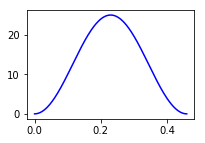

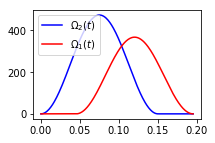

In [5]:
'''
Define the pump pulse parameters.  The pump pulse by default has a
sin**2 amplitude profile.

Parameters:
    lengthStirap - length of the pump pulse
    wStirap - pi / lengthStirap
    lengthSim - length of the simulation (as the photon can continue to decay
                out of the cavity after the pump pulse is over, we typically
                use lengthSim > lengthStirap).
    OmegaStirap - the peak Rabi frequency of the pump pulse.  Note that, again,
                  this does not include the angualr dependence of the
                  transition so the Rabi frequency on a given transition is
                        A * OmegaStirap
                where,
                    A: Angular dependence of the considered transition.
                e.g. A=np.sqrt(5/24) for F=1,mF=+/-1 <--> F=1,mF=1 in zero
                magnetic field.
'''
lengthStirap=0.46
OmegaStirap = 25*2*np.pi

print('Peak Rabi frequency of pump pulse for F=1,mF=+/-1 <--> F=1,mF=0 '
      'in zero magnetic field is: Omega={0}MHz'.format(
        np.round(np.sqrt(5/24) * OmegaStirap/ (2*np.pi),3))) 

wStirap = np.pi / lengthStirap

t,tStep = np.linspace(0, lengthStirap, 251, retstep=True)

Omega = lambda t, A=OmegaStirap, w=wStirap: A*(np.sin(w*t)**2)

args_omega_stirap = dict([('wStirap',wStirap)])

f, a1 = plt.subplots(figsize=(3, 2))
a1.plot(t, [Omega(x)/(2*np.pi) for x in t], 'b')
f.patch.set_facecolor('white')


'''
Define the repumping pulse parameters.  This repumping is performed using two
lasers to drive a Raman transition between the ground |1,-1> <--> |2,-2> levels.

There are two routes for this, which we label with the polarisation of the
sucessive pulses that drive them:
    |F,mF>-|F',mF'>-|F,mF> <--> |1,-1>-|2,-2>-|2,-2>: 'SigmaPi' repumping,
    |F,mF>-|F',mF'>-|F,mF> <--> |1,-1>-|2,-2>-|2,-2>: 'PiSigma' repumping.
    
The code below automatically sets the peak Rabi frequency of each pulse to be 
the same (I believe this gives maximal population transfer efficiency), but
note that with the different coupling strengths of each transition this
requires different driving powers.

The pulses by default has a sin**2 amplitude profile.

Parameters:
    length1/length2 - length of the first/second repumping pulse.
    w1/w2 - pi / length1 and pi/length2
    lengthDelay - The offset between the peak of each pulse.
    lengthRepump - The overall time taken for driving the repumping transition.
    A - The peak Rabi frequency of the pulses, corrected for the coupling strength.
    A1/A2 - The peak Rabi frequency of the pulses, uncorrected for the coupling strength. 
    t0_1/t0_2 - The start time of each pulse.
'''

######For SigmaPi repumping#####

[length2,length1,lengthDelay]=[0.2,0.2,0.08]
lengthRepump = lengthDelay + (length1 + length2)/2

A = 45

[A2,A1] = [abs(x)*2*np.pi for x in [A/CGg2MMx2MM,A/CGg1Mx2MM]]

##########

######For PiSigma repumping######

[length2,length1,lengthDelay]=[0.15,0.15,0.045]
lengthRepump = lengthDelay + (length1 + length2)/2
A = 140
[A2,A1] = [abs(x)*2*np.pi for x in [A/CGg2MMx2M,A/CGg1Mx2M]]

##########

print('Peak Rabi frequency of repumping pulses, corrected for coupling '
      'strength, is {0}MHz on both tranistions'.format(
        np.round(A / (2*np.pi),3))) 

[w2,w1] = [1*np.pi / l for l in [length2,length1]]
t,tStep = np.linspace(0, lengthRepump, 251, retstep=True)

t0_2 = lengthRepump/2-lengthDelay/2-length2/2
t0_1 = lengthRepump/2+lengthDelay/2-length1/2

Omega2 = lambda t: np.piecewise(t, [t<t0_2+length2], [A2*np.sin(w2*(t-t0_2))**2,0])
Omega1 = lambda t: np.piecewise(t, [t>t0_1], [A1*np.sin(w1*(t-t0_1))**2,0])

args_omega_repump = dict([('w2',w2),('w1',w1),
                   ('lengthRepump', lengthRepump), ('t0_2', t0_2), ('t0_1', t0_1),
                   ('length1',length2),('length2',length2),('lengthDelay',lengthDelay)])

f, a1 = plt.subplots(figsize=(3, 2))
a1.plot(t, [Omega2(x)/(2*np.pi) for x in t], 'b',label='$\Omega_2(t)$')
a1.plot(t, [Omega1(x)/(2*np.pi) for x in t], 'r',label='$\Omega_1(t)$')
a1.legend(loc=2)
f.patch.set_facecolor('white')

In [6]:
'''
Create couplings for the Hamiltonian
'''

'''
Create a laser coupling.

Parameters:
    Omega - The peak rabi frequency of the pump pulse.
    gLev - The ground atomic atomic level.
    xLev - The excited atomic level.
    omegaL - The detuning of the pump laser.
    args_list - A dictionary of arguments for the qutip simulation.
    pulseShape - The shape of the pump pulse.
    
Returns:
    (List of cython-ready Hamiltonian terms,
     args_list with relevant parameters added)
'''
def laserCoupling(Omega,gLev,xLev,omegaL,args_list,pulseShape='np.sin(w*t)**2'):
     omegaL_lab = 'omegaL_{0}{1}'.format(gLev,xLev)
     args_list[omegaL_lab] = omegaL
     return (
         [
         [ -(Omega/2)*(
                ( kb([gLev,0],[xLev,0]) + kb([gLev,1],[xLev,1]) ) +
                ( kb([xLev,0],[gLev,0]) + kb([xLev,1],[gLev,1]) )
        ),'{0} * np.cos({1}*t)'.format(pulseShape,omegaL_lab)],
        [ -i*(Omega/2)*(
                ( kb([gLev,0],[xLev,0]) + kb([gLev,1],[xLev,1]) ) -
                ( kb([xLev,0],[gLev,0]) + kb([xLev,1],[gLev,1]) )
        ),'{0} * np.sin({1}*t)'.format(pulseShape,omegaL_lab)]
         ],
     args_list
     )
    
'''
Create a cavity coupling.

Parameters:
    g - The atom-cavity coupling rate.
    gLev - The ground atomic atomic level.
    xLev - The excited atomic level.
    omegaC - The detuning of the cavity resonance.
    args_list - A dictionary of arguments for the qutip simulation.
    
Returns:
    (List of cython-ready Hamiltonian terms,
     args_list with relevant parameters added)
'''
def cavityCoupling(g,gLev,xLev,omegaC,args_list):
    omegaC_lab = 'omegaC_{0}{1}'.format(gLev,xLev)
    args_list[omegaC_lab] = omegaC
    return (
        [
            [ -g*(
                 kb([gLev,1],[xLev,0])+ kb([xLev,0],[gLev,1]) 
        ),'np.cos({0}*t)'.format(omegaC_lab)],
        [ -i*g*(
                 kb([gLev,1],[xLev,0]) - kb([xLev,0],[gLev,1]) 
        ),'np.sin({0}*t)'.format(omegaC_lab)]
            ],
        args_list
    )

'''
The laser couplings for STIRAP 'SigmaPi' repumping with
    |F,mF>-|F',mF'>-|F,mF> <--> |1,-1>-|2,-2>-|2,-2>
'''
def getCouplingsF1_Sigma(delta):
    return [ 
    # For |F,mF>=|1,mF> <--> |F',mF'>=|3,mF+/-1>
    (CGg1Mx3MM, 'g1M', 'x3MM', delta + deltaZ - deltaZx3MM - deltaEx3),
    (CGg1Mx3,   'g1M', 'x3',   delta + deltaZ - deltaZx3 - deltaEx3),
    (CGg1x3M,   'g1',  'x3M',  delta - deltaZx3M - deltaEx3),
    (CGg1x3P,   'g1',  'x3P',  delta - deltaZx3P - deltaEx3),
    (CGg1Px3,   'g1P', 'x3',   delta - deltaZ - deltaZx3 - deltaEx3),
    (CGg1Px3PP, 'g1P', 'x3PP', delta - deltaZ - deltaZx3PP - deltaEx3),
    # For |F,mF>=|1,mF> <--> |F',mF'>=|2,mF+/-1>
    (CGg1Mx2MM, 'g1M', 'x2MM', delta + deltaZ - deltaZx2MM),
    (CGg1Mx2,   'g1M', 'x2',   delta + deltaZ - deltaZx2),
    (CGg1x2M,   'g1',  'x2M',  delta - deltaZx2M),
    (CGg1x2P,   'g1',  'x2P',  delta - deltaZx2P),
    (CGg1Px2,   'g1P', 'x2',   delta - deltaZ - deltaZx2),
    (CGg1Px2PP, 'g1P', 'x2PP', delta - deltaZ - deltaZx2PP),
    # For |F,mF>=|1,mF> <--> |F',mF'>=|1,mF+/-1>
    (CGg1Mx1,   'g1M', 'x1',   delta + deltaZ - deltaZx1 - deltaEx1),
    (CGg1x1M,   'g1',  'x1M',  delta - deltaZx1M - deltaEx1),
    (CGg1x1P,   'g1',  'x1P',  delta - deltaZx1P - deltaEx1),
    (CGg1Px1,   'g1P', 'x1',   delta - deltaZ - deltaZx1 - deltaEx1),
    # For |F,mF>=|1,mF> <--> |F',mF'>=|0,mF+/-1>
    (CGg1Mx0,   'g1M', 'x0',   delta + deltaZ - deltaZx0 - deltaEx0),
    (CGg1Px0,   'g1P', 'x0',   delta - deltaZ - deltaZx0 - deltaEx0),
    ]

def getCouplingsF2_Pi(delta):
    return [ 
    # For |F,mF>=|2,mF> <--> |F',mF'>=|3,mF>
    (CGg2MMx3MM, 'g2MM', 'x3MM', delta - 2*deltaZ - deltaZx3MM - deltaEx3),
    (CGg2Mx3M,   'g2M',  'x3M',  delta -   deltaZ - deltaZx3M - deltaEx3),
    (CGg2x3,     'g2',   'x3',   delta - deltaZx3 - deltaEx3),
    (CGg2Px3P,   'g2P',  'x3P',  delta +   deltaZ - deltaZx3P - deltaEx3),
    (CGg2PPx3PP, 'g2PP', 'x3PP', delta + 2*deltaZ - deltaZx3PP - deltaEx3),
    # For |F,mF>=|2,mF> <--> |F',mF'>=|2,mF>
    (CGg2MMx2MM, 'g2MM', 'x2MM', delta - 2*deltaZ - deltaZx2MM),
    (CGg2Mx2M,   'g2M',  'x2M',  delta -   deltaZ - deltaZx2M),
    (CGg2x2,     'g2',   'x2',   delta - deltaZx2),
    (CGg2Px2P,   'g2P',  'x2P',  delta +   deltaZ - deltaZx2P),
    (CGg2PPx2PP, 'g2PP', 'x2PP', delta + 2*deltaZ - deltaZx2PP),
    # For |F,mF>=|2,mF> <--> |F',mF'>=|1,mF>
    (CGg2Mx1M,   'g2M',  'x1M',  delta -   deltaZ - deltaZx1M - deltaEx1),
    (CGg2x1,     'g2',   'x1',   delta - deltaZx1 - deltaEx1),
    (CGg2Px1P,   'g2P',  'x1P',  delta +   deltaZ - deltaZx1P - deltaEx1),
    # For |F,mF>=|2,mF> <--> |F',mF'>=|0,mF>
    (CGg2x0,     'g2',   'x0',   delta - deltaZx0 - deltaEx0),
    ]

'''
The laser couplings for STIRAP 'PiSigma' repumping with
    :|F,mF>-|F',mF'>-|F,mF> <--> |1,-1>-|2,-1>-|2,-2>
'''
def getCouplingsF1_Pi(delta):
    return [ 
    # For |F,mF>=|1,mF> <--> |F',mF'>=|3,mF>
    (CGg1Mx3M, 'g1M', 'x3M', delta + deltaZ - deltaZx3M - deltaEx3),
    (CGg1x3,   'g1',  'x3',  delta - deltaZx3 - deltaEx3),
    (CGg1Px3P, 'g1P', 'x3P', delta - deltaZ - deltaZx3P - deltaEx3),
    # For |F,mF>=|1,mF> <--> |F',mF'>=|2,mF>
    (CGg1Mx2M, 'g1M', 'x2M', delta + deltaZ - deltaZx2M),
    (CGg1x2,   'g1',  'x2',  delta - deltaZx2),
    (CGg1Px2P, 'g1P', 'x2P', delta - deltaZ - deltaZx2P),
    # For |F,mF>=|1,mF> <--> |F',mF'>=|1,mF>
    (CGg1Mx1M, 'g1M', 'x1M', delta + deltaZ - deltaZx1M - deltaEx1),
    (CGg1x1,   'g1',  'x1',  delta - deltaZx1 - deltaEx1),
    (CGg1Px1P, 'g1P', 'x1P', delta - deltaZ - deltaZx1P - deltaEx1),
    # For |F,mF>=|1,mF> <--> |F',mF'>=|0,mF>
    (CGg1x0,   'g1',  'x0',  delta - deltaZx0 - deltaEx0),
    ]

def getCouplingsF2_Sigma(delta):
    return [
    # For |F,mF>=|2,mF> <--> |F',mF'>=|3,mF+/-1>
    (CGg2MMx3MMM, 'g2MM', 'x3MMM', delta - 2 * deltaZ - deltaZx3MMM - deltaEx3),
    (CGg2MMx3M,   'g2MM', 'x3M',   delta - 2 * deltaZ - deltaZx3M - deltaEx3),
    (CGg2Mx3MM,   'g2M',  'x3MM',  delta - deltaZ - deltaZx3MM - deltaEx3),
    (CGg2Mx3,     'g2M',  'x3',    delta - deltaZ - deltaZx3 - deltaEx3),
    (CGg2x3M,     'g2',   'x3M',   delta - deltaZx3M - deltaEx3),
    (CGg2x3P,     'g2',   'x3P',   delta - deltaZx3P - deltaEx3),
    (CGg2Px3,     'g2P',  'x3',    delta + deltaZ - deltaZx3 - deltaEx3),
    (CGg2Px3PP,   'g2P',  'x3PP',  delta + deltaZ - deltaZx3PP - deltaEx3),
    (CGg2PPx3P,   'g2PP', 'x3P',   delta + 2 * deltaZ - deltaZx3P - deltaEx3),
    (CGg2PPx3PPP, 'g2PP', 'x3PPP', delta + 2 * deltaZ - deltaZx3PPP - deltaEx3),
    # For |F,mF>=|2,mF> <--> |F',mF'>=|2,mF+/-1>
    (CGg2MMx2M,   'g2MM', 'x2M',   delta - 2 * deltaZ - deltaZx2M),
    (CGg2Mx2MM,   'g2M',  'x2MM',  delta - deltaZ - deltaZx2MM),
    (CGg2Mx2,     'g2M',  'x2',    delta - deltaZ - deltaZx2),
    (CGg2x2M,     'g2',   'x2M',   delta - deltaZx2M),
    (CGg2x2P,     'g2',   'x2P',   delta - deltaZx2P),
    (CGg2Px2,     'g2P',  'x2',    delta + deltaZ - deltaZx2),
    (CGg2Px2PP,   'g2P',  'x2PP',  delta + deltaZ - deltaZx2PP),
    (CGg2PPx2P,   'g2PP', 'x2P',   delta + 2 * deltaZ - deltaZx2P),
    # For |F,mF>=|2,mF> <--> |F',mF'>=|1,mF+/-1>
    (CGg2MMx1M,   'g2MM', 'x1M',   delta - 2 * deltaZ - deltaZx1M - deltaEx1),
    (CGg2Mx1,     'g2M',  'x1',    delta - deltaZ - deltaZx1 - deltaEx1),
    (CGg2x1M,     'g2',   'x1M',   delta - deltaZx1M - deltaEx1),
    (CGg2x1P,     'g2',   'x1P',   delta - deltaZx1P - deltaEx1),
    (CGg2Px1,     'g2P',  'x1',    delta + deltaZ - deltaZx1 - deltaEx1),
    (CGg2PPx1P,   'g2PP', 'x1P',   delta + 2 * deltaZ - deltaZx1P - deltaEx1),
    # For |F,mF>=|2,mF> <--> |F',mF'>=|0,mF+/-1>
    (CGg2Mx0,     'g2M',  'x0',    delta - deltaZ - deltaZx0 - deltaEx0),
    (CGg2Px0,     'g2P',  'x0',    delta + deltaZ - deltaZx0 - deltaEx0)
    ]

'''
Define the couplings used here.
'''
# Couplings used for vSTIRAP.
cavityCouplings_F1 = getCouplingsF1_Sigma(deltaC)
laserCouplings_F2_Pi_Stirap = getCouplingsF2_Pi(deltaL2_Pi_Stirap)

# Couplings used for repumping.
laserCouplingsF1_Sigma = getCouplingsF1_Sigma(deltaL1_Sigma)
laserCouplingsF2_Pi = getCouplingsF2_Pi(deltaL2_Pi)
laserCouplingsF2_Sigma = getCouplingsF2_Sigma(deltaL2_Sigma)
laserCouplingsF1_Pi = getCouplingsF1_Pi(deltaL1_Pi)

'''
Convert a list of couplings as returned by getCouplings...() to a list
of time dependent Hamiltonian terms as required by qutip.mesolve(...).

Needs: couplings:  the list of couplings as returned by getCouplings...()
       rabiFreq:   the intensity of the couplings (with angular dependence factored out)
       pulseShape: the shape of the pulse (in the string format for mesolve compilation
                   into Cython.
                   If None the coupling is presumed constant and a cavityCoupling(...)
                   is set, otherwise laserCoupling(...) is used.

Returns: hams: the list of Hamiltonian terms
         args_hams: the dictionary of args needed by qutip.mesolve
'''
def couplingsToHamiltonians(couplings, rabiFreq, pulseShape=None):
    hams, args_hams = [], dict()
    for x in couplings:
        # Check if this is a coupling between configured states.
        if  x[1] in atomStates and x[2] in atomStates:
            if pulseShape != None:
                ham, args_ham = laserCoupling(rabiFreq*x[0], x[1], x[2], x[3], args_hams, pulseShape) 
            else:
                ham, args_ham = cavityCoupling(rabiFreq*x[0], x[1], x[2], x[3], args_hams) 
            hams.append(ham)
    return list(chain(*hams)), args_hams

# Create Hamiltonian terms for cavity coupling and vSTIRAP
hams_cavity, args_hams_cavity = couplingsToHamiltonians(cavityCouplings_F1, d*coupling_factor)
hams_F2_Pi_Stirap, args_hams_F2_Pi_Stirap = couplingsToHamiltonians(laserCouplings_F2_Pi_Stirap, OmegaStirap,
                                                                    'np.sin(wStirap*t)**2')

# Create Hamiltonian terms for SigmaPi STIRAP repumping with
#     |F,mF>-|F',mF'>-|F,mF> <--> |1,-1>-|2,-2>-|2,-2>
[A2,A1] = [abs(x)*2*np.pi for x in [A/CGg2MMx2MM,A/CGg1Mx2MM]]
hams_F1_Sigma, args_hams_F1_Sigma = couplingsToHamiltonians(laserCouplingsF1_Sigma,A1,
                                                            'np.piecewise(t, [t>t0_1], [np.sin(w1*(t-t0_1))**2,0])')
hams_F2_Pi,    args_hams_F2_Pi    = couplingsToHamiltonians(laserCouplingsF2_Pi,   A2,
                                                            'np.piecewise(t, [t<t0_2+length2], [np.sin(w2*(t-t0_2))**2,0])')

# Create Hamiltonian for PiSigma STIRAP repumping with|
#     F,mF>-|F',mF'>-|F,mF> <--> |1,-1>-|2,-1>-|2,-2>
[A2,A1] = [abs(x)*2*np.pi for x in [A/CGg2MMx2M,A/CGg1Mx2M]]
hams_F1_Pi,    args_hams_F1_Pi    = couplingsToHamiltonians(laserCouplingsF1_Pi,   A1,
                                                            'np.piecewise(t, [t>t0_1], [np.sin(w1*(t-t0_1))**2,0])')
hams_F2_Sigma, args_hams_F2_Sigma = couplingsToHamiltonians(laserCouplingsF2_Sigma,A2,
                                                            'np.piecewise(t, [t<t0_2+length2], [np.sin(w2*(t-t0_2))**2,0])')

args_hams_Stirap = {**args_omega_stirap,**args_hams_cavity,**args_hams_F2_Pi_Stirap}
args_hams_SigmaPiRepump = {**args_omega_repump,**args_hams_cavity,**args_hams_F1_Sigma,**args_hams_F2_Pi}
args_hams_PiSigmaRepump = {**args_omega_repump,**args_hams_cavity,**args_hams_F1_Pi,**args_hams_F2_Sigma}
args_hams_FullRepump = {**args_omega_repump,**args_hams_cavity,**args_hams_F1_Sigma,**args_hams_F1_Pi,**args_hams_F2_Sigma}

H_Stirap = list(chain(*[hams_cavity, hams_F2_Pi_Stirap]))
H_SigmaPiRepump = list(chain(*[hams_cavity, hams_F1_Sigma, hams_F2_Pi]))
H_PiSigmaRepump = list(chain(*[hams_cavity, hams_F1_Pi,    hams_F2_Sigma]))

In [7]:
'''
Here we define Hamiltonians in an equivilent manner to those for vSTIRAP
photon production and STIRAP repumping above, however we consider a third
possible action: appyling a Pi and Sigma polarised pulse to either clear
F=2 before repumping begins or to clear F=1 after repumping ends.

I have not found these particularly advantageous but feel free to play
around with them!
'''

deltaPulse= 2*deltaZ + deltaZx2MM # Pulse detuning
lengthPulse = 0.2 # Pulse length

'''
Pulses to clear F=2 before repumping begins.
'''
laserCouplingsF2_Pi_Pulse = getCouplingsF2_Pi(deltaPulse)
laserCouplingsF2_Sigma_Pulse = getCouplingsF2_Sigma(deltaPulse)

hams_F2_PiPulse, args_hams_F2_PiPulse = couplingsToHamiltonians(laserCouplingsF2_Pi_Pulse,
                                                                70*2*np.pi,
                                                                '1')
hams_F2_SigmaPulse, args_hams_F2_SigmaPulse = couplingsToHamiltonians(laserCouplingsF2_Sigma_Pulse,
                                                                      25*2*np.pi,
                                                                      '1')
args_hams_F2_PiPulse = {**args_hams_cavity,**args_hams_F2_PiPulse}
args_hams_F2_SigmaPulse = {**args_hams_cavity,**args_hams_F2_SigmaPulse}

H_F2_PiPulse = list(chain(*[hams_cavity, hams_F2_PiPulse]))
H_F2_SigmaPulse = list(chain(*[hams_cavity, hams_F2_SigmaPulse]))

'''
Pulses to clear F=1 after repumping ends.
'''

laserCouplingsF1_Pi_Pulse = getCouplingsF1_Pi(deltaPulse)
laserCouplingsF1_Sigma_Pulse = getCouplingsF1_Sigma(deltaPulse)

hams_F1_PiPulse, args_hams_F1_PiPulse = couplingsToHamiltonians(laserCouplingsF1_Pi_Pulse,
                                                                70*2*np.pi,
                                                                '1')
hams_F1_SigmaPulse, args_hams_F1_SigmaPulse = couplingsToHamiltonians(laserCouplingsF1_Sigma_Pulse,
                                                                      70*2*np.pi,
                                                                      '1')

args_hams_F1_PiPulse = {**args_hams_cavity,**args_hams_F1_PiPulse}
args_hams_F1_SigmaPulse = {**args_hams_cavity,**args_hams_F1_SigmaPulse}

H_F1_PiPulse = list(chain(*[hams_cavity, hams_F1_PiPulse]))
H_F1_SigmaPulse = list(chain(*[hams_cavity, hams_F1_SigmaPulse]))

In [8]:
'''
When repeatedly simulating a system where only the time-dependent variables,
or initial state change, it is possible to reuse the Hamiltonian data stored
in QuTiP and there by avoid spending time needlessly preparing the Hamiltonian
and collapse terms for simulation. To turn on the the reuse features, we must
pass a qutip.Options object with the rhs_reuse flag turned on, or we can
pre-compile the Hamiltonian and pass it explicitly to the solver. 
'''

# A list of Hamiltonians to pre-compile in the form:
#    (Cythonised Hamiltonian, arguement dictionary, compiled file name)
H_list = [
    (H_Stirap, args_hams_Stirap, 'H_Stirap'),
    
    (H_SigmaPiRepump, args_hams_SigmaPiRepump, 'H_SigmaPi_Repump'), 
    (H_PiSigmaRepump, args_hams_PiSigmaRepump, 'H_PiSigma_Repump'),
    # 
    (H_F2_PiPulse, args_hams_F2_PiPulse, 'H_F2_PiPulse'),
    (H_F2_SigmaPulse, args_hams_F2_SigmaPulse, 'H_F2_SigmaPulse')
    # (H_F1_PiPulse, args_hams_F1_PiPulse, 'H_F1_PiPulse'),
    # (H_F1_SigmaPulse, args_hams_F1_SigmaPulse, 'H_F1_SigmaPulse')
]

H_rhs_compiled=[]

for H, args, label in H_list:
    t_start = time.time()
    rhs_generate(H, c_op_list, args=args, name=label, cleanup=False)
    H_rhs_compiled.append(H)
    print('Hamiltonian \'{0}\': states pre-computed in in {1} seconds'.format(label, time.time()-t_start))

Hamiltonian 'H_Stirap': states pre-computed in in 10.642513990402222 seconds


Hamiltonian 'H_SigmaPi_Repump': states pre-computed in in 20.760735988616943 seconds


Hamiltonian 'H_PiSigma_Repump': states pre-computed in in 21.949826955795288 seconds


Hamiltonian 'H_F2_PiPulse': states pre-computed in in 8.0624840259552 seconds


Hamiltonian 'H_F2_SigmaPulse': states pre-computed in in 11.70924425125122 seconds


In [9]:
'''
Perform simulation
'''
tStirap,tStirapStep = np.linspace(0, lengthStirap, 51, retstep=True)
tRepump,tRepumpStep = np.linspace(0, lengthRepump, 51, retstep=True)
tPulse,tPulseStep = np.linspace(0, lengthPulse, 51, retstep=True)

psi0 = ket(*['g2MM',0]) # Initial state of the system

n_Cycles = 4 # Number of times to apply the sequence of actions defined in H_list

# The actions to apply in terms of a list of the form
#      (Cythonised Hamiltonian,
#       list of time steps,
#       arguement dictionary,
#       compiled file name)
H_list = [
    (H_Stirap, tStirap, args_hams_Stirap, 'H_Stirap'),

    # (H_F2_PiPulse, tPulse, args_hams_F2_PiPulse, 'H_F2_PiPulse'),
    # (H_F2_SigmaPulse, tPulse, args_hams_F2_SigmaPulse, 'H_F2_SigmaPulse'),
    
   (H_PiSigmaRepump, tRepump, args_hams_PiSigmaRepump, 'H_PiSigma_Repump') # Better choice
    #(H_SigmaPiRepump, tRepump, args_hams_SigmaPiRepump, 'H_SigmaPi_Repump')
    
    # (H_F1_PiPulse, tPulse, args_hams_F1_PiPulse, 'H_F1_PiPulse')
    #(H_F1_SigmaPulse, tPulse, args_hams_F1_SigmaPulse, 'H_F1_SigmaPulse')
    
    # (H_FullRepump, tRepump, args_hams_FullRepump, 'H_Full_Repump')
    ]

for H_info in H_list:
    if H_info[0] not in H_rhs_compiled:  print( 
      'WARNING: The Hamiltonian does not match the form of the \
      Hamiltonian pre-complied to Cython by Qutip.\n \
      Consider re-running the \'rhs_generate(...)\' function (i.e. the above cell hopefully)'
      )

psi=psi0
i, n_hams = 0, len(H_list)*n_Cycles
output_states_list = []
t_list = []
for H, t, args, label in H_list*n_Cycles:

    opts = Options(rhs_reuse=False,rhs_filename=label)
    t_start = time.time()
    
    output = mesolve(H, psi, t, c_op_list, [], args=args, options=opts, progress_bar=None)
    
    i+=1
    print('Simulation {0}/{1} with {2} timesteps completed in {3} seconds'.format(
            i, n_hams, t.size,np.round(time.time()-t_start,3) ))
    
    output_states_list.append(output.states)
    t_list.append(t)

    psiList=[]
    for k in aDict:
        for b in aDict:
            psiList.append(((output.states[-1]*arhoDict[k,b]).tr() ,  ket(*[k,0])*bra(*[b,0])))
            
    psi = sum([x*y for x,y in psiList])

Simulation 1/8 with 51 timesteps completed in 0.924 seconds


Simulation 2/8 with 51 timesteps completed in 5.321 seconds


Simulation 3/8 with 51 timesteps completed in 1.028 seconds


Simulation 4/8 with 51 timesteps completed in 4.874 seconds


Simulation 5/8 with 51 timesteps completed in 1.104 seconds


Simulation 6/8 with 51 timesteps completed in 5.321 seconds


Simulation 7/8 with 51 timesteps completed in 0.993 seconds


Simulation 8/8 with 51 timesteps completed in 5.193 seconds


Looking at output after H_Stirap is applied.
Photon emission from cavity: 0.619
Total spontaneous emission: 0.467
Ratio of cavity to spontaneous emission: 1.326
Final pops: |2,-2>,|1,-1>: 0.062 0.854
Final pops: |2,0>,|1,0>: 0.003 0.004


/anaconda3/envs/rb-cqed-env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


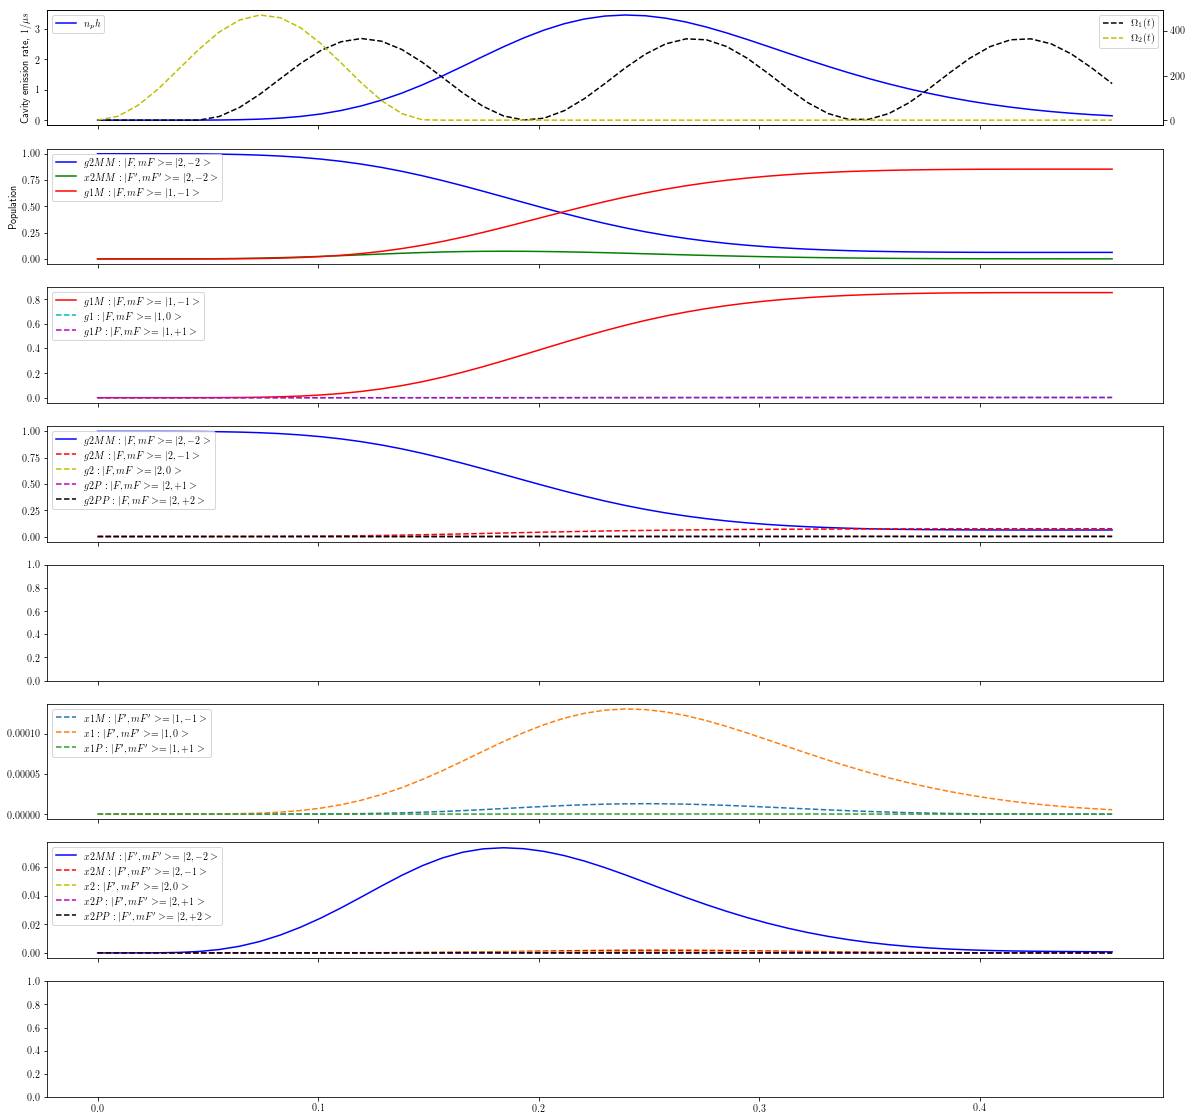

In [10]:
'''
Handle simulation results.  Here we produce plots showing the evolution of the
system during a particular driving sequence (as indexed by iOutput).

'''
iOutput=0
print('Looking at output after {0} is applied.'.format( (H_list*n_Cycles)[iOutput][-1] ))
output_states = output_states_list[iOutput]
t=t_list[iOutput]
tStep=(t[-1]-t[0])/(len(t)-1)

# Expectation value of photon number operator.
exp_an = np.real( np.array([(x*an).tr() for x in output_states]) )

# Expectation value of atomic state populations.
exp_ag2MM = np.real( np.array([(x*ag2MM).tr() for x in output_states]) )
exp_ax2MM = np.real( np.array([(x*ax2MM).tr() for x in output_states]) )
exp_ag1M = np.real( np.array([(x*ag1M).tr() for x in output_states]) )

[exp_ag1,exp_ag1P,
 exp_ag2M,exp_ag2,exp_ag2P,exp_ag2PP] = [
    np.real( np.array([(x*a).tr() for x in output_states]) ) 
    for a in [ag1,ag1P,
              ag2M,ag2,ag2P,ag2PP]
]

if 'x0' in xlvls: exp_ax0 = np.real( np.array([(x*ax0).tr() for x in output_states]) )

exp_ax1s = []
for x1x, ax1x, lab in zip(
        ['x1M', 'x1','x1P'],
        [ax1M,ax1,ax1P],
        ['|F\',mF\'>=|1,-1>','|F\',mF\'>=|1,0>','|F\',mF\'>=|1,+1>']
):
    if x1x in xlvls:
        exp_ax1s.append( ('${0}: {1}$'.format(x1x,lab), 
                          np.real( np.array([(x*ax1x).tr() for x in output_states]) )) )

[exp_ax2MM,exp_ax2M,exp_ax2,exp_ax2P,exp_ax2PP] = [
    np.real( np.array([(x*a).tr() for x in output_states]) ) 
    for a in [ax2MM,ax2M,ax2,ax2P,ax2PP]
]

exp_ax3s = []
for x3x, ax3x, lab in zip(['x3MMM', 'x3MM','x3M','x3','x3P','x3PP', 'x3PPP'],
                [ax3MMM,ax3MM,ax3M,ax3,ax3P,ax3PP,ax3PPP],
                ['|F\',mF\'>=|3,-3>','|F\',mF\'>=|3,-2>','|F\',mF\'>=|3,-1>',
                 '|F\',mF\'>=|3,0>',
                 '|F\',mF\'>=|3,+1>','|F\',mF\'>=|3,+2>','|F\',mF\'>=|3,+3>']):
    if x3x in xlvls: 
        exp_ax3s.append( ('${0}: {1}$'.format(x3x,lab), 
                          np.real( np.array([(x*ax3x).tr() for x in output_states]) )) )

exp_spontDecay = np.real( np.array([(x*sigma_spontDecayOp).tr() for x in output_states]) )

plt.rcParams['text.usetex'] = True

'''
Calculate total cavity emission and spontaneous emission.
'''
n_ph = np.trapz(2*kappa*exp_an, dx=tStep)
n_spont = np.trapz(exp_spontDecay, dx=tStep)

print('Photon emission from cavity:', np.round(n_ph,3))
print('Total spontaneous emission:', np.round(n_spont,3))
print('Ratio of cavity to spontaneous emission:', np.round(n_ph/n_spont,3))
print('Final pops: |2,-2>,|1,-1>:', np.round(exp_ag2MM[-1],3),np.round(exp_ag1M[-1],3))
print('Final pops: |2,0>,|1,0>:', np.round(exp_ag2[-1],3),np.round(exp_ag1[-1],3))

# Plot the results
f, (a1,a2,a3,a4,a5,a6,a7,a8) = plt.subplots(8, 1, sharex=True, figsize=(20, 20))

a1.plot(t, 2*kappa*exp_an, 'b', label='$n_ph$')
a1.set_ylabel('Cavity emission rate, $1/\mu s$')
a1.legend(loc=2)
a1b = a1.twinx()
# a1b.plot(t, [Omega(x)/(2*np.pi) for x in t], '--k', label='$\Omega(t)$')
a1b.plot(t, [Omega1(x)/(2*np.pi) for x in t], '--k', label='$\Omega_1(t)$')
a1b.plot(t, [Omega2(x)/(2*np.pi) for x in t], '--y', label='$\Omega_2(t)$')
a1b.legend(loc=0)

a2.plot(t, exp_ag2MM,  'b', label='$g2MM:|F,mF>=|2,-2>$')
a2.plot(t, exp_ax2MM,  'g', label='$x2MM:|F\',mF\'>=|2,-2>$')
a2.plot(t, exp_ag1M,   'r', label='$g1M: |F,mF>=|1,-1>$')
a2.set_ylabel('Population')
a2.legend(loc=2)

a3.plot(t, exp_ag1M,   'r', label='$g1M: |F,mF>=|1,-1>$')
a3.plot(t, exp_ag1,  '--c', label='$g1:  |F,mF>=|1,0>$')
a3.plot(t, exp_ag1P, '--m', label='$g1P: |F,mF>=|1,+1>$')
a3.legend(loc=2)

a4.plot(t, exp_ag2MM,  'b', label='$g2MM:|F,mF>=|2,-2>$')
a4.plot(t, exp_ag2M, '--r', label='$g2M: |F,mF>=|2,-1>$')
a4.plot(t, exp_ag2,  '--y', label='$g2:  |F,mF>=|2,0>$')
a4.plot(t, exp_ag2P, '--m', label='$g2P: |F,mF>=|2,+1>$')
a4.plot(t, exp_ag2PP,'--k', label='$g2PP:|F,mF>=|2,+2>$')
a4.legend(loc=2)

if 'x0' in xlvls: a5.plot(t, exp_ax0,  '--y', label='$x0:  |F\',mF\'>=|1,0>$')
a5.legend(loc=2)

# a6.plot(t, exp_ax1M, '--r', label='$x1M: |F\',mF\'>=|1,-1>$')
# a6.plot(t, exp_ax1,  '--y', label='$x1:  |F\',mF\'>=|1,0>$')
# a6.plot(t, exp_ax1P, '--m', label='$x1P: |F\',mF\'>=|1,+1>$')
# a6.legend(loc=2)

for lab, data in exp_ax1s:
    a6.plot(t, data,'--', label=lab)
a6.legend(loc=2)

a7.plot(t, exp_ax2MM,  'b', label='$x2MM:|F\',mF\'>=|2,-2>$')
a7.plot(t, exp_ax2M, '--r', label='$x2M: |F\',mF\'>=|2,-1>$')
a7.plot(t, exp_ax2,  '--y', label='$x2:  |F\',mF\'>=|2,0>$')
a7.plot(t, exp_ax2P, '--m', label='$x2P: |F\',mF\'>=|2,+1>$')
a7.plot(t, exp_ax2PP,'--k', label='$x2PP:|F\',mF\'>=|2,+2>$')
a7.legend(loc=2)

for lab, data in exp_ax3s:
    a8.plot(t, data,'--', label=lab)
a8.legend(loc=2)

In [11]:
'''
This takes the index of a particular action, iOutput, and produces a summary
plot of the atomic populations at the end of this.
'''
def summariseOutputState(iOutput):
    t=t_list[iOutput]
    tStep=(t[-1]-t[0])/(len(t)-1)

    output_states = output_states_list[iOutput]
    final_state = output_states[-1]
    initial_state = output_states[0]

    labs_ag1s, exp_final_ag1s, exp_init_ag1s = [], [], []
    for g1x, ag1x, lab in zip(
            ['g1M', 'g1','g1P'],
            [ag1M,ag1,ag1P],
            ['-1','0','+1']
    ):
        labs_ag1s.append( '${0}: {1}$'.format(g1x,lab) ), 
        exp_final_ag1s.append( np.real( (final_state*ag1x).tr() ) )
        exp_init_ag1s.append( np.real( (initial_state*ag1x).tr() ) )
        
    labs_ag2s, exp_final_ag2s, exp_init_ag2s = [], [], []
    for g2x, ag2x, lab in zip(
            ['g2MM','g2M', 'g2','g2P','g2PP'],
            [ag2MM,ag2M,ag2,ag2P,ag2PP],
            ['-2','-1','0','+1','+2']
    ):
        labs_ag2s.append( '${0}: {1}$'.format(g2x,lab) ), 
        exp_final_ag2s.append( np.real( (final_state*ag2x).tr() ) )
        exp_init_ag2s.append( np.real( (initial_state*ag2x).tr() ) )
        
    exp_an = np.real( np.array([(x*an).tr() for x in output_states]) )    
    exp_spontDecay = np.real( np.array([(x*sigma_spontDecayOp).tr() for x in output_states]) )
    
    n_ph = np.trapz(2*kappa*exp_an, dx=tStep)
    n_spont = np.trapz(exp_spontDecay, dx=tStep)
    
    print('\tPhoton:', np.round(n_ph,3))
    print('\tN. spont. emm by decay operator:', np.round(n_spont,3))
    
    fig = plt.figure(figsize=(10, 3)) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[len(labs_ag1s), len(labs_ag2s)]) 
    a1,a2 = plt.subplot(gs[0]),plt.subplot(gs[1])
       
    width = 0.8   
    for axis, exps_final, exps_init, labs, title in zip(
            [a1,a2],[exp_final_ag1s,exp_final_ag2s], [exp_init_ag1s,exp_init_ag2s],
            [labs_ag1s, labs_ag2s], ['$|F=1,m_F>$','$|F=2,m_F>$']):
        inds=np.arange(len(labs))
        
        rects_init = axis.bar(inds,exps_init,width, color='r', edgecolor='k', linewidth=2, alpha=0.25, ls='--')
        rects_final = axis.bar(inds,exps_final,width, color='b', edgecolor='k', alpha=0.5, linewidth=2)
        
        for r_i,r_f in zip(rects_init,rects_final):
            height_i, height_f = r_i.get_height(), r_f.get_height()
            axis.text(r_f.get_x() + r_f.get_width()/2., height_f+0.02,
                    '$\Delta = {}$'.format(np.round(height_f-height_i,3)),
                    ha='center', va='bottom')
        
        axis.set_xticks(inds)
        axis.set_xticklabels(labs)
        axis.set_ylim([0, 1])
        axis.set_xlabel('State (name: $m_F$)')
        axis.set_ylabel('Population')
        axis.set_title(title)
        
    return fig

Looking at output 2/8 (after H_PiSigma_Repump is applied).

	Photon: 0.017
	N. spont. emm by decay operator: 0.287


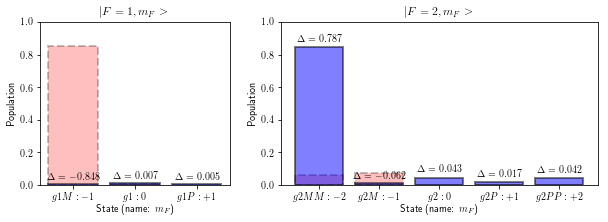

In [12]:
'''
Look at the summary of the system at various points.
'''
iOutput=1

if iOutput<0: iOutput = len(H_list*n_Cycles)+iOutput
print('Looking at output {0}/{1} (after {2} is applied).\n'.format(
        iOutput+1, len(H_list*n_Cycles), (H_list*n_Cycles)[iOutput][-1] ))

pltSummary = summariseOutputState(iOutput)

In [13]:
'''
Iterate through all photon emission attempts - which are assumed to be driven
by a Hamiltonian 'H_Stirap' - and print the total photon emission from the
cavity and total spontaneous emission.

Additionally print a running tally of how likely each emission is to be the
final emission in a fun of three or four consecutive photon emissions. 
'''

i=0
p_Emms, p_threePh, p_fourPh = [], "N/A", "N/A"
for output_states, H_info, t in zip(output_states_list,H_list*n_Cycles, t_list):
    if H_info[-1] == 'H_Stirap':
        
        i+=1
        tStep=(t[-1]-t[0])/(len(t)-1)
        
        exp_an = np.real( np.array([(x*an).tr() for x in output_states]) )    
        exp_spontDecay = np.real( np.array([(x*sigma_spontDecayOp).tr() for x in output_states]) )
        
        n_ph = np.trapz(2*kappa*exp_an, dx=tStep)
        n_spont = np.trapz(exp_spontDecay, dx=tStep)
        
        p_Emms.append(n_ph)
        if len(p_Emms)>=4: 
            p_threePh = np.round(reduce(lambda x,y: x*y, p_Emms[-3:]), 3)
            p_fourPh = np.round( reduce(lambda x,y: x*y, p_Emms[-4:]), 3)
        elif len(p_Emms)==3:
            p_threePh = np.round(reduce(lambda x,y: x*y, p_Emms[-3:]), 3)
        
        print("Emm. attempt {0}: (Photon emm., Spont. emm) = ({1},{2})".format(i, np.round(n_ph,3), np.round(n_spont,3)))
        print("\tProb of 3, 4 photon event with this as final  emission = {0}, {1}".format(p_threePh,p_fourPh))

Emm. attempt 1: (Photon emm., Spont. emm) = (0.619,0.467)
	Prob of 3, 4 photon event with this as final  emission = N/A, N/A
Emm. attempt 2: (Photon emm., Spont. emm) = (0.526,0.432)
	Prob of 3, 4 photon event with this as final  emission = N/A, N/A
Emm. attempt 3: (Photon emm., Spont. emm) = (0.471,0.42)
	Prob of 3, 4 photon event with this as final  emission = 0.153, N/A
Emm. attempt 4: (Photon emm., Spont. emm) = (0.437,0.413)
	Prob of 3, 4 photon event with this as final  emission = 0.108, 0.067


In [169]:
'''
Save summaries to file.
'''
saveFname = "data/"

len_output_states_list = len(output_states_list)
for iOutput in range(len_output_states_list):
    pltSummary = summariseOutputState(iOutput)       
    if saveFname!=None:
        plt_name = 'SummarisedOutput{0}of{1}.pdf'.format(iOutput,len_output_states_list)
        pltSummary.savefig(os.path.join(saveFname, plt_name))
        plt.close(pltSummary)

	Photon: 0.0
	N. spont. emm by decay operator: 0.0


	Photon: 0.003
	N. spont. emm by decay operator: 0.082


	Photon: 0.012
	N. spont. emm by decay operator: 0.421


	Photon: 0.059
	N. spont. emm by decay operator: 1.145


	Photon: 0.11
	N. spont. emm by decay operator: 0.317


	Photon: 0.071
	N. spont. emm by decay operator: 1.072


	Photon: 0.217
	N. spont. emm by decay operator: 0.332


	Photon: 0.065
	N. spont. emm by decay operator: 0.917


	Photon: 0.292
	N. spont. emm by decay operator: 0.347


	Photon: 0.059
	N. spont. emm by decay operator: 0.811


	Photon: 0.341
	N. spont. emm by decay operator: 0.355


	Photon: 0.055
	N. spont. emm by decay operator: 0.742


	Photon: 0.373
	N. spont. emm by decay operator: 0.361


	Photon: 0.052
	N. spont. emm by decay operator: 0.698


	Photon: 0.393
	N. spont. emm by decay operator: 0.364


	Photon: 0.05
	N. spont. emm by decay operator: 0.669


	Photon: 0.406
	N. spont. emm by decay operator: 0.366


	Photon: 0.049
	N. spont. emm by decay operator: 0.651


	Photon: 0.414
	N. spont. emm by decay operator: 0.367


	Photon: 0.048
	N. spont. emm by decay operator: 0.639


	Photon: 0.42
	N. spont. emm by decay operator: 0.368


	Photon: 0.048
	N. spont. emm by decay operator: 0.631


	Photon: 0.423
	N. spont. emm by decay operator: 0.368


	Photon: 0.048
	N. spont. emm by decay operator: 0.626


	Photon: 0.425
	N. spont. emm by decay operator: 0.369


	Photon: 0.047
	N. spont. emm by decay operator: 0.623


	Photon: 0.427
	N. spont. emm by decay operator: 0.369


	Photon: 0.047
	N. spont. emm by decay operator: 0.621


	Photon: 0.428
	N. spont. emm by decay operator: 0.369


	Photon: 0.047
	N. spont. emm by decay operator: 0.62
